# Fine-tuning the SpaCy NER Model for Book Title Extraction

In this notebook, we will further fine-tune the `nl_core_news_lg` pre-trained Named Entity Recognition (NER) model from SpaCy. This model is capable of extracting the entity `work_of_art`, which includes book titles and other artistic works. Our goal is to refine this pre-trained model to better suit our specific needs.

Specifically, we will:
1. **Data Preparation:** Load and Preprocess the data from the Leeuwarder Courant, Het Parool and Trouw.
2. **Model Fine-tuning:** Fine-tune the `nl_core_news_lg` model on the Leeuwarder Courant training dataset to improve its ability to extract book titles accurately.
3. **Evaluation:** Assess the performance of the fine-tuned model on the Leeuwarder Courant test, Het Parool, and Trouw datasets for extracting book titles from newspaper archives.

This process will enhance the model's f1, precision, and recall for the `work_of_art` entity, making it more effective for our specific use case. By the end of this notebook, we aim to have a customized NER model that can reliably identify book titles in historical newspaper texts.

Let's get started!

In [1]:
# !python -m spacy download nl_core_news_sm

In [1]:
import pandas as pd
import numpy as np
import string
import re

from datasets import Dataset, load_metric
from transformers import DataCollatorForTokenClassification, pipeline, AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments

import torch

import spacy
from spacy import displacy

import os
from datetime import datetime
import json

from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score

from spacy.training import Example
from spacy.util import minibatch, compounding
from spacy.tokens import Doc
import random
from datetime import datetime
import matplotlib.pyplot as plt


C:\Users\niels\miniconda3\envs\BookReviewsThesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get the current notebook directory
current_dir = os.path.abspath('')

# Set the main directory (modify as needed to point to your main project directory)
main_dir = os.path.abspath(os.path.join(current_dir, '../'))

# Change the working directory to the main directory
os.chdir(main_dir)

# Verify that the working directory has been set correctly
print(f"Current working directory: {os.getcwd()}")

Current working directory: C:\Users\niels\PycharmProjects\BookReviewsThesis


In [3]:
from scripts.dataset_preparation import remove_punctuation, find_sentence_in_text, create_mask_for_sentence, process_text, \
                                        create_data_set, trouw_parool_create_dataset, save_dataset, load_dataset, split_samples

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
# Load data from Excel and CSV files into DataFrames

# Load leeuwarde courant Excel file into a DataFrame
df_lc = pd.read_excel('data/raw/manullay_check_partially_matched_titles.xlsx', engine='openpyxl')

# Load Trouw and Het Parool annotated book review file into a DataFrame
df_trouw_parool = pd.read_csv('data/raw/trouw_and_parool_annotated_book_titles.csv')

In [6]:
# Define function to remove extra spaces from text
def remove_extra_spaces(text):
    """
    Remove extra spaces from a string by replacing multiple spaces with a single space.

    Args:
        text (str): The input text with potential extra spaces.

    Returns:
        str: The cleaned text with single spaces between words.
    """
    cleaned_text = re.sub(r'\s+', ' ', text)
    return cleaned_text.strip()

In [7]:
# Apply the remove_extra_spaces function to relevant columns in df_lc
df_lc['content'] = df_lc['content'].apply(remove_extra_spaces)
df_lc['title1'] = df_lc['title1'].apply(remove_extra_spaces)
df_lc['title4'] = df_lc['title4'].apply(remove_extra_spaces)

In [8]:
# Filter out rows with 'manually_removed' set to 1 and get unique 'content' values
content_removed = df_lc[df_lc['manually_removed'] == 1]['content'].unique()

# Filter out the removed 'content' values from the main DataFrame
df_lc_clean = df_lc[~df_lc['content'].isin(content_removed)]

In [9]:
# Load the spaCy model for Dutch language processing
nlp = spacy.load("nl_core_news_lg")

In [10]:
# Set flags for punctuation removal and case conversion
remove_punc = False
force_lower_case = False

In [11]:
# Define file paths for saving/loading datasets
lc_train_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/lc_train_dataset.pkl'
lc_val_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/lc_val_dataset.pkl'
lc_test_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/lc_test_dataset.pkl'

trouw_test_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/trouw_test_dataset.pkl'
parool_test_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/parool_test_dataset.pkl'

In [12]:
# Split the samples into training, validation, and test sets

# Set the random seed for reproducibility
np.random.seed(42)

# Get unique content samples
samples = df_lc_clean['content'].unique()

# Split the samples into training, validation, and test sets
lc_train_samples, lc_val_samples, lc_test_samples = split_samples(samples=samples, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

# Check if datasets already exist, otherwise create them
if os.path.exists(lc_train_filename) and os.path.exists(lc_val_filename) and os.path.exists(lc_test_filename):
    print("Loading training, validation, and test datasets....")
    lc_train_dataset = load_dataset(lc_train_filename)
    lc_val_dataset = load_dataset(lc_val_filename)
    lc_test_dataset = load_dataset(lc_test_filename)
else:
    print("Creating training, validation, and test datasets....")
    # Create dataset
    lc_train_dataset = Dataset.from_list(create_data_set(samples=lc_train_samples, df=df_lc_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    lc_val_dataset = Dataset.from_list(create_data_set(samples=lc_val_samples, df=df_lc_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    lc_test_dataset = Dataset.from_list(create_data_set(samples=lc_test_samples, df=df_lc_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))

    # Save dataset, so we don't have to create it everytime again
    save_dataset(lc_train_dataset, lc_train_filename)
    save_dataset(lc_val_dataset, lc_val_filename)
    save_dataset(lc_test_dataset, lc_test_filename)

print("Done...")

Loading training, validation, and test datasets....
Done...


In [13]:
# Create or load the Trouw/Parool test dataset

if os.path.exists(parool_test_filename):
    print("Loading parool test dataset....")
    parool_test_dataset = load_dataset(parool_test_filename)
else:
    print("Creating parool test dataset....")
    parool_test_dataset = Dataset.from_list(trouw_parool_create_dataset(df=df_trouw_parool[df_trouw_parool['newspaper'] == 'Parool'], nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))    
    
    # Save dataset, so we don't have to create it everytime again
    save_dataset(parool_test_dataset, parool_test_filename)


if os.path.exists(trouw_test_filename):
    print("Loading trouw test dataset....")
    trouw_test_dataset = load_dataset(trouw_test_filename)
else:
    print("Creating trouw test dataset....")
    trouw_test_dataset = Dataset.from_list(trouw_parool_create_dataset(df=df_trouw_parool[df_trouw_parool['newspaper'] == 'Trouw'], nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    
    # Save dataset, so we don't have to create it everytime again
    save_dataset(trouw_test_dataset, trouw_test_filename)


Loading parool test dataset....
Loading trouw test dataset....


In [14]:
def merge_entities(entities):
    if not entities:
        return []

    # Sort entities by the start index
    entities.sort()

    # Initialize with the first entity
    merged_entities = [entities[0]]

    for current_start, current_end, current_label in entities[1:]:
        last_start, last_end, last_label = merged_entities[-1]

        # Check if the current entity overlaps or is adjacent to the last entity
        if current_start <= last_end + 1 and current_label == last_label:
            # Merge the current entity with the last one if they are the same type
            merged_entities[-1] = (last_start, max(last_end, current_end), last_label)
        else:
            # Otherwise, add the current entity as a new entity
            merged_entities.append((current_start, current_end, current_label))

    return merged_entities


def convert_data_to_spacy_format(data):
    texts, ner_tags = data['tokens'], data['ner_tags']
    text = ' '.join(texts)
    start_offset, entities = 0, []
    for token, tag in zip(texts, ner_tags):
        end_offset = start_offset + len(token)
        if tag != 0:
            entities.append((start_offset, end_offset, 'WORK_OF_ART'))
        start_offset = end_offset + 1
    entities = merge_entities(entities)
    return Example.from_dict(nlp.make_doc(text), {'entities': entities})

In [15]:
def evaluate_on_unseen_data(val_data_set, trained_nlp):
    all_preds, all_truths = [], []
    for val_data in val_data_set:
        doc = Doc(vocab=trained_nlp.vocab, words=val_data['tokens'])

        doc = trained_nlp.get_pipe('ner')(doc)
        
        preds = [1 if token.ent_type_ == "WORK_OF_ART" else 0 for token in doc]
        all_preds.extend(preds)
        all_truths.extend(val_data['ner_tags'])

    f1 = f1_score(y_true=all_truths, y_pred=all_preds, average='binary')
    precision = precision_score(y_true=all_truths, y_pred=all_preds, average='binary')
    recall = recall_score(y_true=all_truths, y_pred=all_preds, average='binary')
    
    return f1, precision, recall, sum(all_preds)

In [16]:
spacy_train_dataset = []

for i in range(len(lc_train_dataset)):
    data = lc_train_dataset[i]
    spacy_train_dataset.append(convert_data_to_spacy_format(data))

In [17]:
# Check if I can enable GPU

# # Enable GPU
# spacy.prefer_gpu()

In [19]:
base_path = f"models/SpaCy/{datetime.now().strftime('%Y-%m-%d_%H_%M')}/" 
model_export_path = base_path + "model"

# Ensure the export directory exists
os.makedirs(os.path.dirname(model_export_path), exist_ok=True)

In [20]:
best_f1 = 0.0
history = []
disabled_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

with nlp.disable_pipes(*disabled_pipes):
    optimizer = nlp.resume_training()
    for iteration in range(20):
        random.shuffle(spacy_train_dataset)
        losses = {}
        batches = minibatch(spacy_train_dataset, size=compounding(4., 32., 1.001))
        for batch in tqdm(batches, desc=f"Iteration {iteration + 1}"):
            nlp.update(batch, drop=0.5, losses=losses, sgd=optimizer)
            
        f1, precision, recall, sum_preds = evaluate_on_unseen_data(lc_val_dataset, nlp)
        print(f"Iteration {iteration}, Losses: {losses['ner']}, Validation F1: {f1}, Precision: {precision}, Recall: {recall}, Sum of validation predictions: {sum_preds}")
        
        # Append the current iteration's data to the history dictionary
        history.append({
            "iteration": iteration,
            "losses": losses['ner'],
            "validation_f1": f1,
            "precision": precision,
            "recall": recall,
            "sum_of_validation_predictions": sum_preds
        })
        
        # Save the model if the current F1 score is the best seen so far
        if f1 > best_f1:
            best_f1 = f1
            nlp.to_disk(model_export_path)
            print(f"New best model saved with F1: {best_f1}")

Iteration 1: 1207it [08:38,  2.33it/s]


Iteration 0, Losses: 28334.761213369486, Validation F1: 0.5657375356774155, Precision: 0.5594859167617561, Recall: 0.5721304427930971, Sum of validation predictions: 16651
New best model saved with F1: 0.5657375356774155


Iteration 2: 1207it [08:32,  2.36it/s]


Iteration 1, Losses: 23452.617307477307, Validation F1: 0.6020570166356043, Precision: 0.6872586872586872, Recall: 0.5356506786218755, Sum of validation predictions: 12691
New best model saved with F1: 0.6020570166356043


Iteration 3: 1207it [08:29,  2.37it/s]


Iteration 2, Losses: 22356.233645658616, Validation F1: 0.6107128634010355, Precision: 0.6643800996461838, Recall: 0.5650678621875576, Sum of validation predictions: 13849
New best model saved with F1: 0.6107128634010355


Iteration 4: 1207it [08:25,  2.39it/s]


Iteration 3, Losses: 21795.16010253883, Validation F1: 0.6211151885168708, Precision: 0.6590627153687112, Recall: 0.587299637658908, Sum of validation predictions: 14510
New best model saved with F1: 0.6211151885168708


Iteration 5: 1207it [08:27,  2.38it/s]


Iteration 4, Losses: 21082.611077850524, Validation F1: 0.6095995491405491, Precision: 0.6218063362289218, Recall: 0.5978628016950194, Sum of validation predictions: 15656


Iteration 6: 1207it [08:25,  2.39it/s]


Iteration 5, Losses: 20665.43898187658, Validation F1: 0.6339625158407257, Precision: 0.6936437276508793, Recall: 0.5837376404839403, Sum of validation predictions: 13703
New best model saved with F1: 0.6339625158407257


Iteration 7: 1207it [08:25,  2.39it/s]


Iteration 6, Losses: 20161.935149014465, Validation F1: 0.6431201418246284, Precision: 0.7228140087363016, Recall: 0.5792544371430326, Sum of validation predictions: 13049
New best model saved with F1: 0.6431201418246284


Iteration 8: 1207it [08:29,  2.37it/s]


Iteration 7, Losses: 19604.428624125674, Validation F1: 0.639147893554754, Precision: 0.7167060978401892, Recall: 0.5767364736227968, Sum of validation predictions: 13103


Iteration 9: 1207it [09:17,  2.16it/s]


Iteration 8, Losses: 19460.88491319574, Validation F1: 0.624961813923492, Precision: 0.6985885566853848, Recall: 0.5653749309095376, Sum of validation predictions: 13178


Iteration 10: 1207it [13:29,  1.49it/s]


Iteration 9, Losses: 19120.127219654212, Validation F1: 0.6484945414088032, Precision: 0.7473355236797821, Recall: 0.5727445802370571, Sum of validation predictions: 12479
New best model saved with F1: 0.6484945414088032


Iteration 11: 1207it [08:37,  2.33it/s]


Iteration 10, Losses: 18737.350905185813, Validation F1: 0.6428106701366298, Precision: 0.7264705882352941, Recall: 0.5764294049008168, Sum of validation predictions: 12920


Iteration 12: 1207it [08:39,  2.32it/s]


Iteration 11, Losses: 18369.11204915736, Validation F1: 0.6357891906426458, Precision: 0.7022050634791002, Recall: 0.5808511944973285, Sum of validation predictions: 13469


Iteration 13: 1207it [08:36,  2.34it/s]


Iteration 12, Losses: 18200.410093268132, Validation F1: 0.6373297097662103, Precision: 0.7365115155419553, Recall: 0.5616901062457778, Sum of validation predictions: 12418


Iteration 14: 1207it [08:42,  2.31it/s]


Iteration 13, Losses: 18109.016661093578, Validation F1: 0.6407935955447268, Precision: 0.7395356310757613, Recall: 0.5653135171651416, Sum of validation predictions: 12447


Iteration 15: 1207it [08:34,  2.35it/s]


Iteration 14, Losses: 17748.79660274237, Validation F1: 0.627127832592432, Precision: 0.7619884068153873, Recall: 0.5328256463796598, Sum of validation predictions: 11386


Iteration 16: 1207it [08:29,  2.37it/s]


Iteration 15, Losses: 17468.380623147685, Validation F1: 0.6345951451366492, Precision: 0.7095353780747039, Recall: 0.573972855124977, Sum of validation predictions: 13172


Iteration 17: 1207it [08:37,  2.33it/s]


Iteration 16, Losses: 17136.077525420926, Validation F1: 0.6426714657068586, Precision: 0.7026160460540698, Recall: 0.5921513234661917, Sum of validation predictions: 13723


Iteration 18: 1207it [08:44,  2.30it/s]


Iteration 17, Losses: 17069.93132624154, Validation F1: 0.6329462704192088, Precision: 0.6792931070900514, Recall: 0.5925198059325677, Sum of validation predictions: 14203


Iteration 19: 1207it [08:33,  2.35it/s]


Iteration 18, Losses: 16827.112529211547, Validation F1: 0.6269977364702655, Precision: 0.7099805825242719, Recall: 0.5613830375237978, Sum of validation predictions: 12875


Iteration 20: 1207it [08:45,  2.30it/s]


Iteration 19, Losses: 16783.010014363892, Validation F1: 0.6373248744382765, Precision: 0.6897932908947858, Recall: 0.5922741509549837, Sum of validation predictions: 13981


In [21]:
# Export the history dictionary to a JSON file
with open(base_path + "training_history.json", "w") as f:
    json.dump(history, f, indent=4)

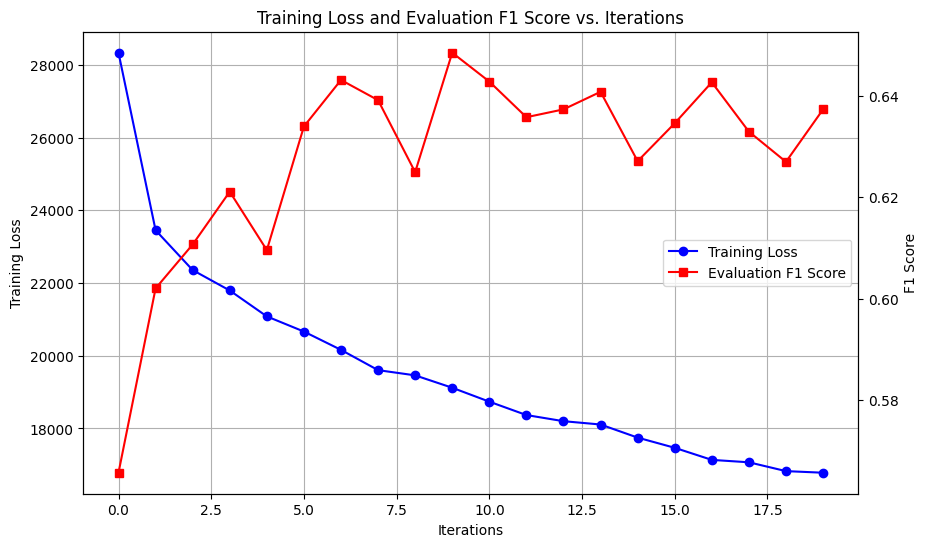

In [28]:
# Convert history list to a DataFrame
training_history = pd.DataFrame(history)

# Create the plot for smoothed training loss
fig, ax1 = plt.subplots(figsize=(10, 6))
line1, = ax1.plot(training_history['iteration'], training_history['losses'], marker='o', color='b', label='Training Loss')
ax1.set_title("Training Loss and Evaluation F1 Score vs. Iterations")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Training Loss")
ax1.grid(True)

# Create secondary y-axis for F1 scores
ax2 = ax1.twinx()
line2, = ax2.plot(training_history['iteration'], training_history['validation_f1'], marker='s', color='r', label='Evaluation F1 Score')
ax2.set_ylabel('F1 Score')

# Combine legends from both axes
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')

plt.show()

In [29]:
# Save the training history plot to a PNG file
fig.savefig(base_path + "training_and_f1_plot.png")

In [18]:
# Load the best model
best_nlp = spacy.load(model_export_path)

In [19]:
lc_f1, lc_precision, lc_recall, _ = evaluate_on_unseen_data(lc_test_dataset, best_nlp)
print(f"LC F1: {lc_f1}, LC precision: {lc_precision}, LC recall: {lc_recall}")

LC F1: 0.6386147307786871, LC precision: 0.743214519293656, LC recall: 0.5598251123837674


In [20]:
trouw_f1, trouw_precision, trouw_recall, _ = evaluate_on_unseen_data(trouw_test_dataset, best_nlp)
print(f"trouw F1: {trouw_f1}, trouw precision: {trouw_precision}, trouw recall: {trouw_recall}")

trouw F1: 0.4074074074074074, trouw precision: 0.7435387673956262, trouw recall: 0.2805701425356339


In [21]:
parool_f1, parool_precision, parool_recall, _ = evaluate_on_unseen_data(parool_test_dataset, best_nlp)
print(f"parool F1: {parool_f1}, parool precision: {parool_precision}, parool recall: {parool_recall}")

parool F1: 0.2756164383561644, parool precision: 0.6995827538247567, parool recall: 0.17161378369157285


In [25]:
doc = best_nlp(lc_test_samples[0])

In [26]:
displacy.render(doc, style="ent", jupyter=True)